# Determine robust velocity dispersion profiles from LAMOST DR4 red clumps - Gaia DR3 data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import agama
import CoordTrans as ct
import scipy.optimize as sciOpt
import matplotlib.pyplot as plt
import matplotlib as mpl

## Read data

In [2]:
datafile   = "../data/LMRC-DR4-VF-SNR30-newnames-GaiaeDR3.csv"
lamostgaia = pd.read_csv(datafile)

solpos = np.array([8.2,0.014,-8.6,13.9+232.8,7.1]) # McMillan 2017

# Collect coordinates (ra/rad, dec/rad, s/kpc, vr/kms-1, mura/masyr-1, 
# mudec/masyr-1, [Fe/H]/dex, [a/Fe]/dex, age/Gyr)
Obs = np.column_stack((lamostgaia["ra"]/180.*np.pi,
                       lamostgaia["dec"]/180.*np.pi,
                       lamostgaia["s"],
                       lamostgaia["vr"],
                       lamostgaia["pmra"],
                       lamostgaia["pmdec"],
                       lamostgaia["feh"],
                       lamostgaia["afe"],
                       lamostgaia["age"]))

eObs = np.column_stack((lamostgaia["ra_error"]/180.*np.pi,
                        lamostgaia["dec_error"]/180.*np.pi,
                        lamostgaia["es"],
                        lamostgaia["evr"],
                        lamostgaia["pmra_error"],
                        lamostgaia["pmdec_error"],
                        lamostgaia["efeh"],
                        lamostgaia["eafe"],
                        lamostgaia["eage"]))

feh = np.copy(lamostgaia["feh"])
afe = np.copy(lamostgaia["afe"])

print("Read LAMOST DR4 red clump supplemented with Gaia eDR3 ...")
                       
# Replace stars with NaN proper motions with original UCAC5 proper motions
index = (np.isnan(lamostgaia["pmra"])) | \
        (np.isnan(lamostgaia["pmdec"])) | \
        (np.isnan(lamostgaia["pmra_error"])) | \
        (np.isnan(lamostgaia["pmdec_error"]))
Obs[index,4]  = lamostgaia["mra"][index]
Obs[index,5]  = lamostgaia["mdec"][index]
eObs[index,4] = lamostgaia["emra"][index]
eObs[index,5] = lamostgaia["emdec"][index]
print("Replaced "+str(np.sum(index))+" stars having NaN proper motions with original UCAC5 proper motions...")

Read LAMOST DR4 red clump supplemented with Gaia eDR3 ...
Replaced 278 stars having NaN proper motions with original UCAC5 proper motions...


## Create pure sample of low-alpha stars

In [3]:
# Remove stars that are likely to be massive merged stars
idx_merged_massive = (afe>0.12) & (Obs[:,8]<5.)
print("Removing "+str(np.sum(idx_merged_massive))+" stars that are likelly to be merged stars.")
Obs  = Obs[~idx_merged_massive,:]
eObs = eObs[~idx_merged_massive,:]
feh  = feh[~idx_merged_massive]
afe  = afe[~idx_merged_massive]

# Remove stars with ages older than the age of the Universe
idx_older_universe = Obs[:,8]>13.1
print("Removing a further "+str(np.sum(idx_older_universe))+" stars that are older than the age of the Universe.")
Obs  = Obs[~idx_older_universe,:]
eObs = eObs[~idx_older_universe,:]
feh  = feh[~idx_older_universe]
afe  = afe[~idx_older_universe]

# Select low-alpha population
slope         = -0.07
yintercept    = 0.12
afemax        = yintercept + slope*feh
idx_lowalpha  = afemax > afe
print("Removing a further "+str(len(feh) - np.sum(idx_lowalpha))+" stars that belong to the high-alpha disc.")
Obs  = Obs[idx_lowalpha,:]
eObs = eObs[idx_lowalpha,:]
feh  = feh[idx_lowalpha]
afe  = afe[idx_lowalpha]

# Number of stars
nstars = len(afe)

Removing 5068 stars that are likelly to be merged stars.
Removing a further 2986 stars that are older than the age of the Universe.
Removing a further 14437 stars that belong to the high-alpha disc.


In [4]:
# Convert coordinates to polar coordinates with errors
nmc    = 100
solpos = np.array([8.2,0.014,-8.6,13.9+232.8,7.1])      

ra     = Obs[:,0]
dec    = Obs[:,1]
s      = Obs[:,2]
vr     = Obs[:,3]
mura   = Obs[:,4]
mudec  = Obs[:,5]
era    = eObs[:,0]
edec   = eObs[:,1]
es     = eObs[:,2]
mulns  = np.log(s/np.sqrt(1.+es**2./s**2.))
siglns = np.sqrt(np.log(1.+es**2./s**2.))
evr    = eObs[:,3]
emura  = eObs[:,4]
emudec = eObs[:,5]

In [5]:
# Generate Monte Carlo samples
ramc    = np.random.normal(ra,era,size=[nmc,nstars])
decmc   = np.random.normal(dec,edec,size=[nmc,nstars])
smc     = np.random.lognormal(mulns,siglns,size=[nmc,nstars])
vrmc    = np.random.normal(vr,evr,size=[nmc,nstars])
muramc  = np.random.normal(mura,emura,size=[nmc,nstars])
mudecmc = np.random.normal(mudec,emudec,size=[nmc,nstars])

In [6]:
# Convert to polar coordinates
wpmc = np.zeros([nmc,nstars,6])
for jmc in range(nmc):
    we = np.column_stack((ramc[jmc,:],decmc[jmc,:],smc[jmc,:],
                          vrmc[jmc,:],muramc[jmc,:],mudecmc[jmc,:]))
    wg            = ct.EquatorialToGalactic(we)
    wpmc[jmc,:,:] = ct.GalacticToPolar(wg,solpos)
    
obsPolar      = np.column_stack((np.mean(wpmc,0),Obs[:,6],Obs[:,7],Obs[:,8]))
obsPolar[:,2] = np.abs(obsPolar[:,2])
eObsPolar     = np.column_stack((np.std(wpmc,0),eObs[:,6],eObs[:,7],Obs[:,8]))

## Kinematic profiles

### 1D vertical dispersion profile using robust method

In [23]:
# Define variables
Rmin          = 2.
Rmax          = 24.
Redges        = np.array([Rmin,7.,7.5,8.,8.5,9.0,9.5,10.,10.5,11.,12.,13.,Rmax])
nR            = len(Redges)-1
agemin        = np.min(obsPolar[:,8])
agemax        = np.max(obsPolar[:,8])
ageedges      = np.array([agemin,2.,3.,4.,5.,6.,7.,8.,9.,agemax])
nage          = len(ageedges)-1
zmin          = 0.0
obsR          = np.zeros(nR)
obsSigmaz     = np.zeros(nR)
obsSigmaz_err = np.zeros(nR)
samplesR      = np.zeros(nR)
samplesSigmaz = np.zeros(nR)
binned_age    = np.zeros(nage)
counts        = np.zeros([nage,nR])

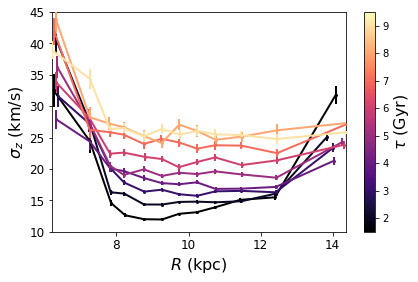

In [24]:
# Define objective function to maximize for estimation of robust velocity dispersion
# sigma - velocity dispersion
# vel   - vector of velocities
# eVel  - vector of velocity uncertainties
# mu    - mean velocity
def sigmaObjFunc(sigma,vel,eVel,mu):
    
    y = ((vel-mu)**2.)/((sigma**2.+eVel**2.)**2.) - (1./(sigma**2.+eVel**2.))
    
    return (np.sum(y))

# Number of sigma for clipping
f = 5.

# Plot each line with a different colour
c = np.arange(1, nage + 1)
plot_agemin = 1.5
plot_agemax = 9.5
norm = mpl.colors.Normalize(vmin=plot_agemin, vmax=plot_agemax)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma)
cmap.set_array([]) 

fig,ax = plt.subplots(1,1,figsize=(6,4))  
obsPlots = []
for jage in range(nage):
    for jR in range(nR):
        
        ## OBSERVATIONS
        # Define R-age box
        boxIndex = ((Redges[jR]<obsPolar[:,0]) & (obsPolar[:,0]<Redges[jR+1]) &\
                    (ageedges[jage]<obsPolar[:,8]) & (obsPolar[:,8]<ageedges[jage+1]))
               
        # Calculate mean velocity
        mean = np.mean(obsPolar[boxIndex,5])
                
        # Calculate initial guess for velocity dispersion
        sigma = np.std(obsPolar[boxIndex,5])
        
        # Clip velocities beyond three sigma
        clippedIndex = (obsPolar[:,5] > (mean-f*sigma)) &\
                       (obsPolar[:,5] < (mean+f*sigma))
        index        = clippedIndex * boxIndex
        
        # Calculate mean radii of clipped velocities
        obsR[jR] = np.mean(obsPolar[index,0])
        
        n = np.sum(index)
        counts[jage,jR] = n
        
        # Recalculate mean
        mean = np.mean(obsPolar[index,5])
        
        # Maximise likelihood to find robust measure of observed velocity dispersion
        intervalMin = 0.
        intervalMax = 100.
        optSigma = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                 args=(obsPolar[index,5],eObsPolar[index,5],mean), 
                                 xtol=2e-12, rtol=8.881784197001252e-16, 
                                 maxiter=100, full_output=False)
        obsSigmaz[jR] = optSigma
        n = np.sum(index)
        obsSigmaz_err[jR] = optSigma * np.sqrt(1./(2.*n))
        
    # Mean age
    ageIndex = (ageedges[jage]<obsPolar[:,8]) & (obsPolar[:,8]<ageedges[jage+1])
    binned_age[jage] = np.mean(obsPolar[ageIndex,8])
    
    pl=ax.errorbar(obsR,obsSigmaz,yerr=obsSigmaz_err,linestyle="-",linewidth=2,fmt="o",color=cmap.to_rgba(jage + 1),ms=2,
                   label="Data",zorder=200)
    obsPlots.append(pl)
    ax.tick_params(axis="x",labelsize=12)
    ax.tick_params(axis="y",labelsize=12)
    ax.set_xlabel(r"$R$ (kpc)",fontsize=16)
    ax.set_ylabel(r"$\sigma_z$ (km/s)",fontsize=16)
    ax.set_xlim([obsR[0],obsR[nR-1]])
    ax.set_ylim([10.,45.])
    
plt.tight_layout(pad=1)
ticks_min = int(np.floor(np.min(binned_age)))
ticks_max = int(np.ceil(np.max(binned_age)))
cbar=plt.colorbar(cmap,ax=ax,ticks=range(ticks_min,ticks_max))
cbar.set_label(r"$\tau$ (Gyr)",size=16)

plotfile = "../plots/data/robustDispersion_byage.eps"
fig.savefig(plotfile,format='eps')

plotfile = "../plots/data/robustDispersion_byage.png"
fig.savefig(plotfile,format='png')

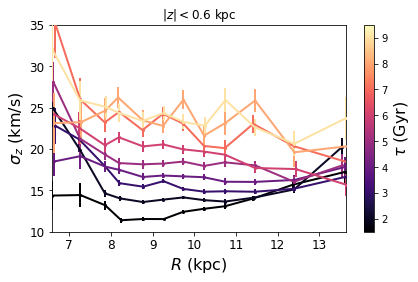

In [25]:
# zmax
zmin = -0.6
zmax = 0.6 
    
fig,ax = plt.subplots(1,1,figsize=(6,4))  
obsPlots = []
for jage in range(nage):
    for jR in range(nR):
        
        ## OBSERVATIONS
        # Define Rz-age box
        boxIndex = ((obsPolar[:,2]>zmin) & (obsPolar[:,2]<zmax) &\
                    (Redges[jR]<obsPolar[:,0]) & (obsPolar[:,0]<Redges[jR+1]) &\
                    (ageedges[jage]<obsPolar[:,8]) & (obsPolar[:,8]<ageedges[jage+1]))
               
        # Calculate mean velocity
        mean = np.mean(obsPolar[boxIndex,5])
        
        # Calculate initial guess for velocity dispersion
        sigma = np.std(obsPolar[boxIndex,5])
        
        # Clip velocities beyond three sigma
        clippedIndex = (obsPolar[:,5] > (mean-f*sigma)) &\
                       (obsPolar[:,5] < (mean+f*sigma))
        index        = clippedIndex * boxIndex
        
        # Calculate mean radii of clipped velocities
        obsR[jR] = np.mean(obsPolar[index,0])
        
        n = np.sum(index)
        counts[jage,jR] = n
        
        # Recalculate mean
        mean = np.mean(obsPolar[index,5])
        
        # Maximise likelihood to find robust measure of observed velocity dispersion
        intervalMin = 0.
        intervalMax = 100.
        optSigma = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                 args=(obsPolar[index,5],eObsPolar[index,5],mean), 
                                 xtol=2e-12, rtol=8.881784197001252e-16, 
                                 maxiter=100, full_output=False)
        obsSigmaz[jR] = optSigma
        n = np.sum(index)
        obsSigmaz_err[jR] = optSigma * np.sqrt(1./(2.*n))
              
    pl=ax.errorbar(obsR,obsSigmaz,yerr=obsSigmaz_err,
                   linestyle="-",linewidth=2,fmt="o",color=cmap.to_rgba(jage + 1),ms=2,
                   label="Data",zorder=200)
    obsPlots.append(pl)
    ax.tick_params(axis="x",labelsize=12)
    ax.tick_params(axis="y",labelsize=12)
    ax.set_xlabel(r"$R$ (kpc)",fontsize=16)
    ax.set_ylabel(r"$\sigma_z$ (km/s)",fontsize=16)
    ax.set_title(r"$|z|<0.6$ kpc")
    ax.set_xlim([obsR[0],obsR[nR-1]])
    ax.set_ylim([10.,35.])
    
plt.tight_layout(pad=1)
cbar=plt.colorbar(cmap,ax=ax,ticks=range(ticks_min,ticks_max))
cbar.set_label(r"$\tau$ (Gyr)",size=16)

plotfile = "../plots/data/robustDispersionz0_byage.eps"
fig.savefig(plotfile,format='eps')

plotfile = "../plots/data/robustDispersionz0_byage.png"
fig.savefig(plotfile,format='png')

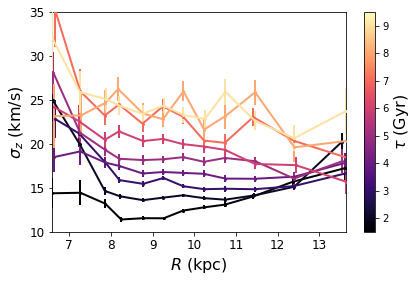

In [26]:
fig,ax = plt.subplots(1,1,figsize=(6,4))  
obsPlots = []
for jage in range(nage):
    for jR in range(nR):
        
        ## OBSERVATIONS
        # Define Rz-age box
        boxIndex = ((obsPolar[:,2]>zmin) & (obsPolar[:,2]<zmax) &\
                    (Redges[jR]<obsPolar[:,0]) & (obsPolar[:,0]<Redges[jR+1]) &\
                    (ageedges[jage]<obsPolar[:,8]) & (obsPolar[:,8]<ageedges[jage+1]))
               
        # Calculate mean velocity
        mean = np.mean(obsPolar[boxIndex,5])
        
        # Calculate initial guess for velocity dispersion
        sigma = np.std(obsPolar[boxIndex,5])
        
        # Clip velocities beyond three sigma
        clippedIndex = (obsPolar[:,5] > (mean-f*sigma)) &\
                       (obsPolar[:,5] < (mean+f*sigma))
        index        = clippedIndex * boxIndex
        
        # Calculate mean radii of clipped velocities
        obsR[jR] = np.mean(obsPolar[index,0])
        
        n = np.sum(index)
        counts[jage,jR] = n
        
        # Recalculate mean
        mean = np.mean(obsPolar[index,5])
        
        # Maximise likelihood to find robust measure of observed velocity dispersion
        intervalMin = 0.
        intervalMax = 100.
        optSigma = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                 args=(obsPolar[index,5],eObsPolar[index,5],mean), 
                                 xtol=2e-12, rtol=8.881784197001252e-16, 
                                 maxiter=100, full_output=False)
        obsSigmaz[jR] = optSigma
        n = np.sum(index)
        obsSigmaz_err[jR] = optSigma * np.sqrt(1./(2.*n))
              
    pl=ax.errorbar(obsR,obsSigmaz,yerr=obsSigmaz_err,linestyle="-",linewidth=2,fmt="o",color=cmap.to_rgba(jage + 1),ms=2,
                   label="Data",zorder=200)
    obsPlots.append(pl)
    ax.tick_params(axis="x",labelsize=12)
    ax.tick_params(axis="y",labelsize=12)
    ax.set_xlabel(r"$R$ (kpc)",fontsize=16)
    ax.set_ylabel(r"$\sigma_z$ (km/s)",fontsize=16)
    #ax.set_title(r"$|z|<1.5$ kpc")
    ax.set_xlim([obsR[0],obsR[nR-1]])
    ax.set_ylim([10.,35.])
    
plt.tight_layout(pad=1)
cbar=plt.colorbar(cmap,ax=ax,ticks=range(ticks_min,ticks_max))
cbar.set_label(r"$\tau$ (Gyr)",size=16)

plotfile = "../plots/data/robustDispersionz1.5_byage.eps"
fig.savefig(plotfile,format='eps')

plotfile = "../plots/data/robustDispersionz1.5_byage.png"
fig.savefig(plotfile,format='png')

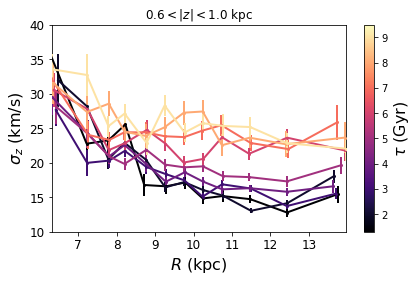

In [27]:
# z range
zmin = 0.6
zmax = 1.   

agemin        = np.min(obsPolar[:,8])
agemax        = np.max(obsPolar[:,8])
ageedges      = np.array([agemin,2.,3.,4.,5.,6.,7.,8.,9.,agemax])
nage          = len(ageedges)-1

c = np.arange(1, nage + 1)
plot_agemin = (ageedges[0]+ageedges[1])/2.
plot_agemax = 9.5#(ageedges[nage-2]+ageedges[nage-1])/2.
norm = mpl.colors.Normalize(vmin=plot_agemin, vmax=plot_agemax)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma)
cmap.set_array([]) 
    
fig,ax = plt.subplots(1,1,figsize=(6,4))  
obsPlots = []
age_split           = 6.
min_sigz_young_ages = np.zeros(nR)+1000.
max_sigz_young_ages = np.zeros(nR)
min_sigz_old_ages   = np.zeros(nR)+1000.
max_sigz_old_ages   = np.zeros(nR)
R_young_ages        = np.zeros(nR)
R_old_ages          = np.zeros(nR)
for jage in range(nage):
               
    for jR in range(nR):
        
        ## OBSERVATIONS
        # Define Rz-age box
        boxIndex = ((obsPolar[:,2]>zmin) & (obsPolar[:,2]<zmax) &\
                    (Redges[jR]<obsPolar[:,0]) & (obsPolar[:,0]<Redges[jR+1]) &\
                    (ageedges[jage]<obsPolar[:,8]) & (obsPolar[:,8]<ageedges[jage+1]))
               
        # Calculate mean velocity
        mean = np.mean(obsPolar[boxIndex,5])
        
        # Calculate initial guess for velocity dispersion
        sigma = np.std(obsPolar[boxIndex,5])
        
        # Clip velocities beyond three sigma
        clippedIndex = (obsPolar[:,5] > (mean-f*sigma)) &\
                       (obsPolar[:,5] < (mean+f*sigma))
        index        = clippedIndex * boxIndex
        
        # Calculate mean radii of clipped velocities
        obsR[jR] = np.mean(obsPolar[index,0])
        
        n = np.sum(index)
        
        # Recalculate mean
        mean = np.mean(obsPolar[index,5])
        
        # Maximise likelihood to find robust measure of observed velocity dispersion
        intervalMin = 0.
        intervalMax = 100.
        optSigma = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                 args=(obsPolar[index,5],eObsPolar[index,5],mean), 
                                 xtol=2e-12, rtol=8.881784197001252e-16, 
                                 maxiter=100, full_output=False)
        obsSigmaz[jR] = optSigma
        n = np.sum(index)
        obsSigmaz_err[jR] = optSigma * np.sqrt(1./(2.*n))
        if (ageedges[jage]<age_split):
            if (optSigma < min_sigz_young_ages[jR]):
                min_sigz_young_ages[jR] = optSigma
            if (optSigma > max_sigz_young_ages[jR]):
                max_sigz_young_ages[jR] = optSigma
        else:
            if (optSigma < min_sigz_old_ages[jR]):
                min_sigz_old_ages[jR] = optSigma
            if (optSigma > max_sigz_old_ages[jR]):
                max_sigz_old_ages[jR] = optSigma
              
    pl=ax.errorbar(obsR,obsSigmaz,yerr=obsSigmaz_err,
                   linestyle="-",linewidth=2,fmt="o",color=cmap.to_rgba(jage + 1),ms=2,
                   label="Data",zorder=200)
    obsPlots.append(pl)
    ax.tick_params(axis="x",labelsize=12)
    ax.tick_params(axis="y",labelsize=12)
    ax.set_xlabel(r"$R$ (kpc)",fontsize=16)
    ax.set_ylabel(r"$\sigma_z$ (km/s)",fontsize=16)
    ax.set_title(r"$0.6<|z|<1.0$ kpc")
    ax.set_xlim([obsR[0],obsR[nR-1]])
    ax.set_ylim([10.,40.])
    
plt.tight_layout(pad=1)
cbar=plt.colorbar(cmap,ax=ax,ticks=range(ticks_min,ticks_max))
cbar.set_label(r"$\tau$ (Gyr)",size=16)

plotfile = "../plots/data/robustDispersionBeyondPlane_byage.eps"
fig.savefig(plotfile,format='eps')

plotfile = "../plots/data/robustDispersionBeyondPlane_byage.png"
fig.savefig(plotfile,format='png')

In [28]:
for jR in range(nR):
        
    ## OBSERVATIONS
    # Define Rz-age box
    index_young_ages = ((obsPolar[:,2]>zmin) & (obsPolar[:,2]<zmax) &\
                        (Redges[jR]<obsPolar[:,0]) & (obsPolar[:,0]<Redges[jR+1]) &\
                        (obsPolar[:,8]<age_split)) 
                        
    index_old_ages = ((obsPolar[:,2]>zmin) & (obsPolar[:,2]<zmax) &\
                      (Redges[jR]<obsPolar[:,0]) & (obsPolar[:,0]<Redges[jR+1]) &\
                      (obsPolar[:,8]>age_split)) 
                      
    R_young_ages[jR] = np.mean(obsPolar[index_young_ages,0])
    R_old_ages[jR]   = np.mean(obsPolar[index_old_ages,0])

In [45]:
young_ages = {'R': R_young_ages, 'min_sigz': min_sigz_young_ages, 'max_sigz':max_sigz_young_ages}
young_ages_df = pd.DataFrame(young_ages)
young_ages_df.to_csv("../data/sigz_young_ages_beyondplane.csv")

old_ages = {'R': R_old_ages, 'min_sigz': min_sigz_old_ages, 'max_sigz':max_sigz_old_ages}
old_ages_df = pd.DataFrame(old_ages)
old_ages_df.to_csv("../data/sigz_old_ages_beyondplane.csv")